Rekha Varrier, 2021-22

- code to extract data from the RT task
- preprocess them: rename rows with dots in the name, remove incomplete/redundant subs, impossibly small RTs, add a column for inconsistent during-after responses
- save the data



In [2]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

os.chdir('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/RT_online_task')
working_dir = os.getcwd()
print('working dir:',working_dir)

working dir: /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/RT_online_task


In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [4]:
movie_names = ['COAXINGB0','BILLIARDA1','DRIFTINGA2','FISHING3','RANDOMMECH4',
              'SCARING5', 'SEDUCINGB6', 'STARA7', 'SURPRISINGB8', 'TENNISA9']

In [5]:
data_folder = r'/Users/f0053cz/Documents/HCP_decision_task_RT_data'
print('num all files:',len(os.listdir(os.path.join(data_folder,'data'))))
csv_files=[f for f in os.listdir(os.path.join(data_folder,'data')) if '.csv' in f]
print('num csv files:',len(csv_files))

num all files: 216
num csv files: 112


In [6]:
# make a list of csv file names
from os import listdir

own_id = '60f5c61782ba68550b8f2cae' # as in my own ID when I preview the task
len(own_id)

def find_csv_filenames(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if ((filename.endswith( suffix )) & \
            (filename[:11] !='PARTICIPANT') & (filename[:24] != own_id))]

filenames = find_csv_filenames(os.path.join(data_folder,'data')) # list of csv files in a folder
len(filenames)


108

In [7]:
# print out feedback from subjects (to get a general impression of how it was for them)
dat_fb = []
for name in filenames:
    try:
        if '2021-07-25' in name: # main_expt_day
            dat = pd.read_csv(os.path.join(data_folder,'data',name))
            if dat.shape[0] > 11: # each video is stored as a row in the csv file
                mat = dat.loc[:,'feedback_text'].values
                mat = mat[-1]
                #print(mat)
                dat_fb.append(mat)

            else:
                print('incomplete sub:', dat['participant'].values[0])
    except:
        print('empty file')
fb = [i for i in dat_fb if len(i)>3]
for i in fb:
    print(i)
print(f'\nfeedback from {len(fb)} people')

incomplete sub: 60fd4227a0da73a530f9c5a7
empty file
empty file
incomplete sub: 60fcd0211918af2f6707ea9d
empty file
empty file
A: this was an interesting excersise
A: wish i had more than  seconds to answer afterwards
A: i felt as if the triangles lived in the square and whenever they interacted it was as if one triangle was kicking the other out of the house or inviting the other inside
A: slightly more instruction
A: was fun
A: this made me question the nature of social interaction entirely,  not sure i know what it  is anymore
A: good animations not a long survey
A: none
A: all was great,  except the last question part.  i wish i could go back and change my answer on one question about the gender 
A: numbering all the questions would be nice to see how many there are
A: perhaps each video numbered to indicate how far into the exercise you are. 
A: i think this survey is actually really good
A: good
A: quite fun
A: long pauses are distracting
A: fun
A: would only allow me to describe 

In [8]:
def extract_rows_cols(data):
    # function to extract certain rows and columns (as needed for analysis) from a single subject's data
    # as a dataframe, define a few new variables and return the new df
    
    for i,m in enumerate(data.loc[:,'fileName'].values):
        if movie_names[0] in str(m):
            start_row  = i
    #print(start_row)
    data_rows = data.iloc[start_row:start_row+10,:]
    data_rows.loc[:,'movie'] = [str(i).split('/')[1].split('.')[0] for i in data_rows.loc[:,'fileName'].values]
    
    movie_ind = np.empty((data_rows.shape[0],))
    for r,movie_row in enumerate(data_rows.loc[:,'movie']):
        for i,m in enumerate(movie_names):
            if movie_row == m:
                movie_ind[r] = i
                break
    #print(movie_ind)
    data_rows.loc[:,'movie_ind'] = movie_ind
    colnames = ['respDur.keys','respDur.rt', 'respAfter.keys', 'respAfter.rt','participant','movie','date','movie_ind']
    data_rows = data_rows.loc[:,colnames] # keep only the desired rows
    
    consistency = np.zeros((data_rows.shape[0],))
    for i in range(data_rows.shape[0]):
        if data_rows.loc[:,'respDur.keys'].values[i] == data_rows.loc[:,'respAfter.keys'].values[i]:
            #same response during and after
            consistency[i] = 1  
        else:
            if data_rows.loc[:,'respAfter.keys'].values[i] in ['left','right']:
                consistency[i] = -1 # response flipped from left -> right or vice versa.
            elif data_rows.loc[:,'respAfter.keys'].values[i] == 'down':
                consistency[i] = 0.5 # response  changed to "unsure"
            elif np.isnan(data_rows.loc[:,'respAfter.keys'].values[i]):
                consistency[i] = 0 # response missed (possibly due to limited RT after)"
                
    data_rows.loc[:,'consistency'] = consistency
    return data_rows

#example to see that the code works
s = 15 #file nr
extract_rows_cols(pd.read_csv(os.path.join(data_folder,'data',filenames[s]))).head()
    


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,respDur.keys,respDur.rt,respAfter.keys,respAfter.rt,participant,movie,date,movie_ind,consistency
1,left,7.0192,left,1.1695,60fd530ff30159b5785d34d7,COAXINGB0,2021-07-25_09h49.10.548,0.0,1.0
2,right,15.1607,down,2.7923,60fd530ff30159b5785d34d7,BILLIARDA1,2021-07-25_09h49.10.548,1.0,0.5
3,right,15.8680,right,1.0867,60fd530ff30159b5785d34d7,DRIFTINGA2,2021-07-25_09h49.10.548,2.0,1.0
4,left,7.9749,left,0.5625,60fd530ff30159b5785d34d7,FISHING3,2021-07-25_09h49.10.548,3.0,1.0
5,left,13.5669,left,0.5200,60fd530ff30159b5785d34d7,RANDOMMECH4,2021-07-25_09h49.10.548,4.0,1.0


In [35]:
# extract the required rows and columns using the function defined above, save it as one long dataframe

inds = [0,30]#np.arange(0,len(filenames))
for name in filenames:
    try:
        if '2021-07-25' in name: # correct day of acquisition
            dat = pd.read_csv(os.path.join(data_folder,'data',name))
            if dat.shape[0] > 11: # each video is stored as a row in the csv file, so completed subs should have at least 11 rows (at least because there could be multiple rows of demos depending on how many times they repeated)
                dat = extract_rows_cols(dat)

                if name == filenames[0]:
                    dat_all = pd.DataFrame(dat, columns = dat.columns)
                    print('creating the df..')
                else:
                    #print('else')
                    dat_all = dat_all.append(dat,ignore_index=True)
                    #print(dat_all)

            else:
                print('incomplete sub:', dat['participant'].values[0],', skipping..')
    except:
        print('empty file, skipping..')
        
print('\nAll extracted. \n\nrows/columns: ',dat_all.shape)
dat_all.head() 

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


creating the df..
incomplete sub: 60fd4227a0da73a530f9c5a7 , skipping..
empty file, skipping..
empty file, skipping..
incomplete sub: 60fcd0211918af2f6707ea9d , skipping..
empty file, skipping..
empty file, skipping..

All extracted. 

rows/columns:  (1020, 9)


,respDur.keys,respDur.rt,respAfter.keys,respAfter.rt,participant,movie,date,movie_ind,consistency
0,left,3.070585,left,0.868510,60fd5d01137be0173165dcfe,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0
1,right,1.909830,right,0.669700,60fd5d01137be0173165dcfe,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0
2,right,2.362310,right,0.497975,60fd5d01137be0173165dcfe,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0
3,left,4.312300,left,1.568915,60fd5d01137be0173165dcfe,FISHING3,2021-07-25_08h39.36.916,3.0,1.0
4,right,1.539055,right,0.667690,60fd5d01137be0173165dcfe,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0


In [36]:
count_resp = dat_all.groupby(['participant']).count()['respDur.keys'].reset_index()
repeat_sub = count_resp.loc[count_resp['respDur.keys']==20,'participant'].values[0] # this subject did the task twice
dat_all = dat_all.loc[dat_all['participant']!=repeat_sub,:]
dat_all.shape


(1000, 9)

In [37]:

sub_ids = np.unique(dat_all['participant'].values) # count unique subs
len(sub_ids)


100

In [38]:
# nr of prolific ids`
prolific_approved = pd.read_excel(os.path.join(data_folder, 'demographics_maindata', 'Prolific_subs.xlsx'))
prolificIDs = prolific_approved['participant_id'].values
len(prolificIDs)


101

In [39]:
# quality check 1: are the data of APPROVED subs on Prolific and saved data (who's not me) the same?
print('not on prolific:')
for i in range(len(sub_ids)):
    if sub_ids[i] not in prolificIDs: # if there's a subject who's not on Prolific
        print(sub_ids[i])
        
print('..\nnot on pavlovia')
for i in range(len(prolificIDs)):
    if prolificIDs[i] not in sub_ids: # if there's a subject who's not on Pavlovia (this subject did the task twice)
        print(prolificIDs[i])
print('..')

not on prolific:
..
not on pavlovia
60fd295a26f11be0bcb4b13a
..


In [40]:
#quality check 2: are there any subjects who repeat? If so, remove them

sub_ids = np.unique(dat_all['participant'].values)

for i in sub_ids:
    rows = np.where(dat_all['participant'].values==i)[0]
    if len(rows) > 10: # more than 10 rows per subject (since we only have the movie rows now) - executed this step already before, so no more data
        print(dat_all.iloc[rows,:]) # print subs who repeat
        dat_all = dat_all.loc[dat_all['participant']!=i,:]

dat_all.shape # 100 subs after removing redundancies

(1000, 9)

In [41]:
# preproc 1: remove trials with impossibly small RTs for during or after
rt_min = .1 #100ms
rows = (dat_all['respDur.rt'] > rt_min) | (dat_all['respAfter.rt'] > rt_min)
dat_all = dat_all.loc[rows,:]
dat_all.shape

(999, 9)

In [42]:
# preproc 2: remove trials with no "during" response at all - since that's our main question here

rows = (dat_all['respDur.keys'] == 'left') | (dat_all['respDur.keys'] == 'right')
dat_all = dat_all.loc[rows,:]
dat_all.shape

(994, 9)

<AxesSubplot:>

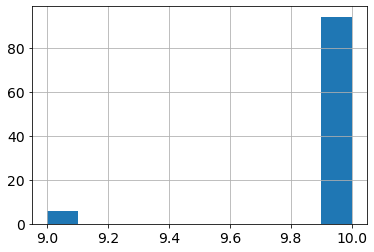

In [44]:
dat_all.groupby(['participant']).count()['respDur.keys'].hist()
# looks like there's no need remove incomplete subs, since everyone has at least 9/10

In [45]:
# rename '.' in colnames with '_' to avoid errors while accessing columns using the dot operator

cols = []
for i in dat_all.columns:
    if '.' in i:
        cols.append(i)

cols_new = [i.replace('.','_') for i in cols]
df = pd.DataFrame({'cols':cols, 'cols_new':cols_new})
dictcol = df.set_index('cols').to_dict()['cols_new']    

dat_all = dat_all.rename(columns = dictcol)

dat_all

,respDur_keys,respDur_rt,respAfter_keys,respAfter_rt,participant,movie,date,movie_ind,consistency
0,left,3.070585,left,0.868510,60fd5d01137be0173165dcfe,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0
1,right,1.909830,right,0.669700,60fd5d01137be0173165dcfe,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0
2,right,2.362310,right,0.497975,60fd5d01137be0173165dcfe,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0
3,left,4.312300,left,1.568915,60fd5d01137be0173165dcfe,FISHING3,2021-07-25_08h39.36.916,3.0,1.0
4,right,1.539055,right,0.667690,60fd5d01137be0173165dcfe,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0
...,...,...,...,...,...,...,...,...,...
1015,left,7.740700,left,0.696100,60fd20e2fcd0da955a2b7b3c,SCARING5,2021-07-25_16h57.42.386,5.0,1.0
1016,left,4.984500,left,0.574300,60fd20e2fcd0da955a2b7b3c,SEDUCINGB6,2021-07-25_16h57.42.386,6.0,1.0
1017,left,4.825600,NaN,NaN,60fd20e2fcd0da955a2b7b3c,STARA7,2021-07-25_16h57.42.386,7.0,0.0
1018,left,0.688400,left,1.417700,60fd20e2fcd0da955a2b7b3c,SURPRISINGB8,2021-07-25_16h57.42.386,8.0,1.0


In [46]:
subs_ID = np.unique(dat_all['participant'])
sub_ind = np.arange(100)
subs_ID_key =  pd.DataFrame({'subs_ID':subs_ID, 'sub_ind': sub_ind})
subs_ID_key.to_csv(os.path.join(data_folder,'subj_IDs_key_DONOTSHARE.csv'))  
  

In [47]:
sub_ind_all = np.empty((dat_all.shape[0],))
sub_ind_all[:] = np.nan
for s in range(subs_ID_key.shape[0]):
    ID,ind = subs_ID_key.iloc[s,:]
    rows = dat_all['participant'] == ID
    sub_ind_all[rows] = int(ind)

In [48]:
dat_all.insert(0, "sub_ind", sub_ind_all)
dat_all

In [51]:
del dat_all['participant']
dat_all

,sub_ind,respDur_keys,respDur_rt,respAfter_keys,respAfter_rt,movie,date,movie_ind,consistency
0,86.0,left,3.070585,left,0.868510,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0
1,86.0,right,1.909830,right,0.669700,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0
2,86.0,right,2.362310,right,0.497975,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0
3,86.0,left,4.312300,left,1.568915,FISHING3,2021-07-25_08h39.36.916,3.0,1.0
4,86.0,right,1.539055,right,0.667690,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0
...,...,...,...,...,...,...,...,...,...
1015,37.0,left,7.740700,left,0.696100,SCARING5,2021-07-25_16h57.42.386,5.0,1.0
1016,37.0,left,4.984500,left,0.574300,SEDUCINGB6,2021-07-25_16h57.42.386,6.0,1.0
1017,37.0,left,4.825600,NaN,NaN,STARA7,2021-07-25_16h57.42.386,7.0,0.0
1018,37.0,left,0.688400,left,1.417700,SURPRISINGB8,2021-07-25_16h57.42.386,8.0,1.0


In [52]:
# save this dataframe (can be saved in unsecure locs now too, because identifying info was removed)
final_data_folder = r'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/RT_online_task'
dat_all.to_csv(os.path.join(final_data_folder,'RT_data_all_subs.csv'))

In [30]:
dat_all

,respDur_keys,respDur_rt,respAfter_keys,respAfter_rt,participant,movie,date,movie_ind,consistency
0,left,3.070585,left,0.868510,60fd5d01137be0173165dcfe,COAXINGB0,2021-07-25_08h39.36.916,0.0,1.0
1,right,1.909830,right,0.669700,60fd5d01137be0173165dcfe,BILLIARDA1,2021-07-25_08h39.36.916,1.0,1.0
2,right,2.362310,right,0.497975,60fd5d01137be0173165dcfe,DRIFTINGA2,2021-07-25_08h39.36.916,2.0,1.0
3,left,4.312300,left,1.568915,60fd5d01137be0173165dcfe,FISHING3,2021-07-25_08h39.36.916,3.0,1.0
4,right,1.539055,right,0.667690,60fd5d01137be0173165dcfe,RANDOMMECH4,2021-07-25_08h39.36.916,4.0,1.0
...,...,...,...,...,...,...,...,...,...
1015,left,7.740700,left,0.696100,60fd20e2fcd0da955a2b7b3c,SCARING5,2021-07-25_16h57.42.386,5.0,1.0
1016,left,4.984500,left,0.574300,60fd20e2fcd0da955a2b7b3c,SEDUCINGB6,2021-07-25_16h57.42.386,6.0,1.0
1017,left,4.825600,NaN,NaN,60fd20e2fcd0da955a2b7b3c,STARA7,2021-07-25_16h57.42.386,7.0,0.0
1018,left,0.688400,left,1.417700,60fd20e2fcd0da955a2b7b3c,SURPRISINGB8,2021-07-25_16h57.42.386,8.0,1.0
